In [1]:
import numpy as np
import lmfit

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
mpl.rc("savefig", dpi=1200)

%matplotlib inline

# Source of equations
Chris Homes et al., Phys. Rev. B 102, 155135 (2020)  
https://journals.aps.org/prb/abstract/10.1103/PhysRevB.102.155135

# Connections between symbols
Define expressions optical conductivity. 
Most papers are (annoyingly) in csg units, so we progagate the misery.

$R$, $n$, $k$, $\epsilon$ are unitless. 

$\sigma$ has units $\Omega^{-1}$cm$^{-1}$  
$Z_0 = 377$ $\Omega$  

In [2]:
Z0_val = 377
unitconvert = 8065.73 # 1 eV in cm-1

def get_ep_minus_ep_inf(omega, Omega_k, omega_k, gamma_k):
    return Omega_k**2/(omega_k**2 - omega**2 - 1j*omega*gamma_k)

def get_sigma(omega, Omega_k=10, omega_k=100, gamma_k=50):
    ep_minus_ep_inf = get_ep_minus_ep_inf(omega, Omega_k, omega_k, gamma_k)
    sigma = -2*np.pi*1j*omega*ep_minus_ep_inf/Z0_val
    return sigma

def get_sigma_1(omega, Omega_k=10, omega_k=100, gamma_k=50):
    sigma = get_sigma(omega, Omega_k, omega_k, gamma_k)
    sigma1 = np.real(sigma)
    return sigma1

# Source of values
[Phys. Rev. B 80, 195110 (2009)](https://doi.org/10.1103/PhysRevB.80.195110)
extracted using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/).

Text(0.5, 0, 'Energy (eV)')

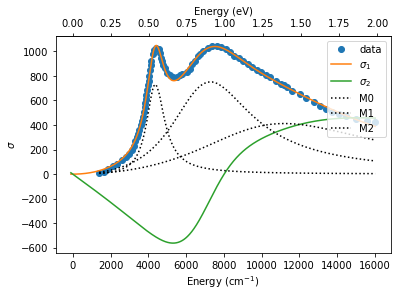

In [3]:
omegadata_eV, sigma1data = np.loadtxt('sigma_1.csv', delimiter=',', unpack=True)

omegadata = omegadata_eV*unitconvert

num_osciallators = 3

def make_model(i, just_real=True):
    if just_real:
        return lmfit.Model(get_sigma_1, independent_vars=['omega'], prefix='M{}_'.format(i))
    else:
        return lmfit.Model(get_sigma, independent_vars=['omega'], prefix='M{}_'.format(i))

model = sum([make_model(i) for i in range(1, num_osciallators)], make_model(0))

params = model.make_params()

guess_w = [4500, 8000, 16000]
guess_g = [100,  1000, 5000]
guess_W = [5000,  10000, 10000]

[params['M{}_omega_k'.format(i)].set(value=value, min=0) for i, value in enumerate(guess_w)]
[params['M{}_gamma_k'.format(i)].set(value=value, min=10) for i, value in enumerate(guess_g)]
[params['M{}_Omega_k'.format(i)].set(value=value, min=0) for i, value in enumerate(guess_W)]

result = model.fit(sigma1data, omega=omegadata, params=params)

# result.plot_fit(show_init=True)
fig, ax = plt.subplots()

ax.plot(omegadata, sigma1data, 'o', label='data')
model_complex = sum([make_model(i, just_real=False)
                     for i in range(1, num_osciallators)], make_model(0))

om_grid = np.linspace(-100, omegadata.max(), 10000)
sigma_complex_fit = model_complex.eval(result.params, omega=om_grid)
ax.plot(om_grid, np.real(sigma_complex_fit), label='$\sigma_1$')
ax.plot(om_grid, np.imag(sigma_complex_fit), label='$\sigma_2$')
ax.set_xlabel('Energy (cm$^{-1}$)')
ax.set_ylabel('$\sigma$')
# print(result.fit_report())

for name, y in result.eval_components().items():
    ax.plot(omegadata, y, 'k:', label=name[:-1])

ax.legend(loc='upper right')


secax = ax.secondary_xaxis('top', functions=(lambda x:x/unitconvert, lambda x:x/unitconvert))
secax.set_xlabel('Energy (eV)')

In [4]:
def cos(alpha):
    return np.cos(alpha*np.pi/180)

def compute_penetration(lam, epsilon, alpha):
    """get penetration 
    
    parameters
    ------
    lam : float
        wavelength. The answer will be returned in these units
    epsilon : float or array
        complex conductivity
    alpha : float or array
        incident angle w.r.t. surface in degrees
        
    returns
    -----
    Lambda : float or array
        penetration in the same units as lam
        defined as 1/e in *intensity*
        
    """
    Lambda = lam/(4*np.pi*np.imag(np.sqrt(epsilon - cos(alpha)**2)))
    return Lambda

Text(0.3, 0.3, 'Penetration at 0.5 ev\n0.038 microns')

<ipython-input-5-06228a3d9552>:27: RuntimeWarning: divide by zero encountered in true_divide
  secax = ax.secondary_xaxis('top', functions=(lambda x:1.23984/x, lambda x:1.23984/x))


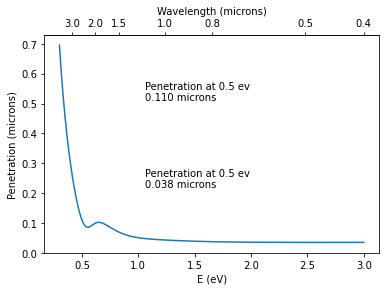

In [5]:
E = np.linspace(.3, 3, 1000) # eV

def get_penetration(E):
    alpha = 10 # deg
    omega_values = E*unitconvert   # cm-1
    lam = 1.2398/E # microns
    sigma_complex = model_complex.eval(result.params, omega=omega_values)
    epsilon_complex = 1 - Z0_val*sigma_complex/(2*np.pi*1j*omega_values)
    Lambda = compute_penetration(lam, epsilon_complex, alpha)
    return Lambda

Lambda = get_penetration(E)

def E2wav(x):
    return 1.2398/x

def wav2E(x):
    return 

fig, ax = plt.subplots()

ax.plot(E, Lambda)
ax.set_xlabel('E (eV)')
ax.set_ylabel('Penetration (microns)')
ax.set_ylim(bottom=0)

secax = ax.secondary_xaxis('top', functions=(lambda x:1.23984/x, lambda x:1.23984/x))

secax.set_ticks([10, 0.1, 0.5, 0.75, 1, 1.5, 2, 3, 1.23984/3])
import matplotlib
secax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.1f}'))

secax.set_xlabel('Wavelength (microns)')

Lambda_0p5eV = get_penetration(.5)
ax.text(0.3, 0.7, f"Penetration at 0.5 ev\n{Lambda_0p5eV:.3f} microns", transform=ax.transAxes)

Lambda_1p55eV = get_penetration(1.55)
ax.text(0.3, 0.3, f"Penetration at 0.5 ev\n{Lambda_1p55eV:.3f} microns", transform=ax.transAxes)